In [1]:
import sys, os, time
# %load_ext autoreload
# %autoreload 2
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = '/is/ei/fleeb/workspace/chome/trained_nets'
os.environ['FOUNDATION_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data'
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
from IPython import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision
from torch.utils.data import Dataset, DataLoader, TensorDataset
import gym
import numpy as np
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import imageio
import seaborn as sns
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn
#from foundation.util import replicate, Cloner

from hybrid import get_model, get_data
from analyze import *

np.set_printoptions(linewidth=120, suppress=True)

In [2]:
# dataset = trn.get_dataset('celeba')
# len(dataset)

In [3]:
fmt = 'mpi3d_{}.npz'
cat = 'real'

In [4]:
path = os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'mpi3d', fmt.format(cat))
path

'/is/ei/fleeb/workspace/local_data/mpi3d/mpi3d_real.npz'

In [5]:
data = np.load(path)
list(data.keys())

['images']

In [6]:
images = data['images']
images.shape

(1036800, 64, 64, 3)

In [7]:
# plt.imshow(images[1])
# plt.axis('off')
# pass

In [86]:
sizes = np.array([6,6,2,3,3,40,40,])#64,64,3])
sizes = sizes[::-1]

In [87]:
# sizes[:] = 10

In [88]:
cap = np.cumprod(sizes)
cap

array([     40,    1600,    4800,   14400,   28800,  172800, 1036800])

In [89]:
flr = cap.copy()
flr[1:] = flr[:-1]
flr[0] = 1
flr

array([     1,     40,   1600,   4800,  14400,  28800, 172800])

In [99]:
idx = np.random.randint(np.product(sizes))
idx = 40*40*3*3*2*1
# idx = 0
idx

28800

In [100]:
lvls = idx // flr
digits = lvls % sizes
digits[::-1]
# digits

array([0, 1, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>


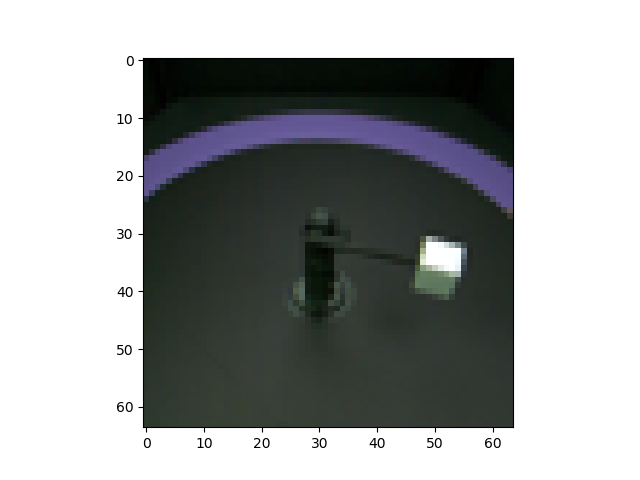

In [101]:
plt.imshow(images[idx])

In [22]:
dataset = trn.get_dataset('atari', game='MsPacman')
len(dataset)

Loading dataset: atari
dataroot: /is/ei/fleeb/workspace/local_data
game: MsPacman
train: True (by default)
Found 20 datafiles. Using 16


320000

In [23]:
border, between = 0.02, 0.01

In [24]:
util.set_seed(0)
B = 16
idx = np.random.randint(len(dataset), size=(B,))
idx

array([305711, 117952, 152315, 304137, 122579,  86293, 211543, 212038, 310744, 170584, 314764,  80186,  17089, 150055,
       220760, 255653])

In [25]:
# X, = dataset[idx]

X = []
for i in idx:
    X.append(dataset[i][0])
X = torch.stack(X)
X = X.to('cuda')
B = X.size(0)
X.shape

torch.Size([16, 3, 128, 128])

<IPython.core.display.Javascript object>


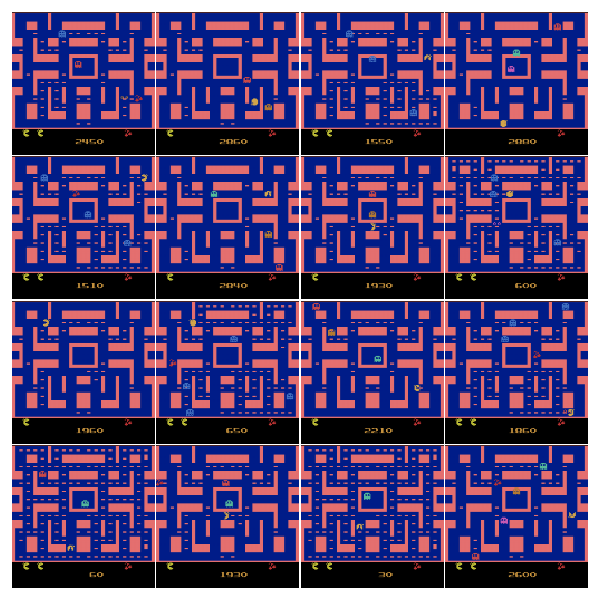

In [26]:
fig = show_nums(X)
plt.subplots_adjust(wspace=between, hspace=between,
	                    left=border, right=1 - border, bottom=border, top=1 - border)
pass

In [4]:
# C = trn.get_config('n/t/box-s2')

/is/ei/fleeb/workspace/foundation/foundation/train/config.py:42: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f)


In [19]:
# dataset = trn.get_dataset(info=C.dataset)

In [20]:
# len(dataset)

<IPython.core.display.Javascript object>


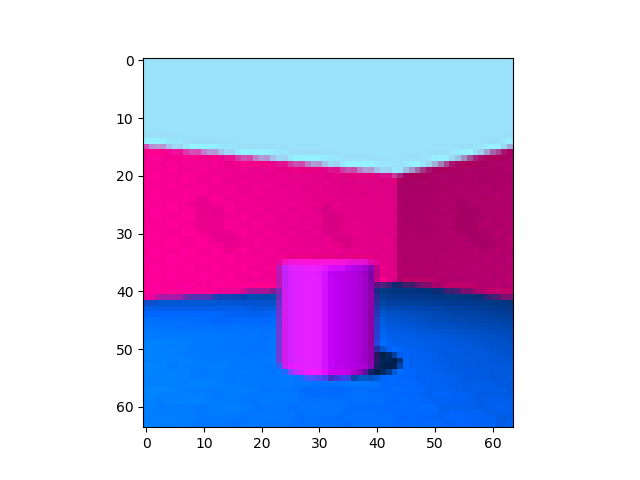

In [2]:
box = trn.get_config()
box._type = 'dataset/byfactor'
box.counts = [100, 0, 0, 0]

cyl = trn.get_config()
cyl._type = 'dataset/byfactor'
cyl.counts = [0, 100, 0, 0]

sph = trn.get_config()
sph._type = 'dataset/byfactor'
sph.counts = [0, 0, 100, 0]

cap = trn.get_config()
cap._type = 'dataset/byfactor'
cap.counts = [0, 0, 0, 100]

ls = trn.get_config()
ls._type = 'list'
ls._elements = [box, cyl, sph]

ls.factor = 'shape'
ls.labeled = False

In [3]:
D = trn.get_config()
D._type = 'dataset/concat'
D.datasets = ls

dataset = trn.get_dataset(info=D)
len(dataset)

  datasets (type=list): 
  Creating (0) (type=dataset/byfactor)
    factor: shape (by default)
    vals: None (by default)
    counts: [100, 0, 0, 0]
    seeds: None (by default)
    det: True (by default)
    labeled: False (by default)
    dataroot: None (by default)
    load_memory: True (by default)
    train: True (by default)
    labeled: True
    noise: None (by default)
    din: (3, 64, 64) (by default)
    dout: 6 (by default)
{{'_type':'dataset/byfactor', 'counts':[100, 0, 0, 0], 'labeled':True}}


AttributeError: 'ByFactor' object has no attribute 'labels'

In [3]:
dataset.inds

tensor([39063,  4642,  6324, 74654, 28312, 93244, 47231, 54767, 86206, 49797])

In [7]:
X, Y = dataset[np.arange(5)]
X.shape, Y.shape

(torch.Size([5, 3, 64, 64]), torch.Size([5, 6]))

In [8]:
Y

tensor([[  0.4000,   0.0000,   0.6000,   0.8929,   0.0000, -30.0000],
        [  0.0000,   0.4000,   0.7000,   1.2500,   0.0000, -21.4286],
        [  0.0000,   0.6000,   0.5000,   0.8929,   0.0000, -25.7143],
        [  0.7000,   0.7000,   0.7000,   1.1071,   0.0000, -21.4286],
        [  0.2000,   0.9000,   0.4000,   1.1071,   0.0000,  -4.2857]])

In [3]:
# dataset = trn.get_dataset('byfactor', factor='shape', counts=[4,20,0,0], labeled=True)
len(dataset)

Loading dataset: byfactor
factor: shape
vals: None (by default)
counts: [4, 20, 0, 0]
seeds: None (by default)
det: True (by default)
labeled: True
dataroot: /is/ei/fleeb/workspace/local_data
load_memory: True (by default)
train: True (by default)
labeled: True
noise: None (by default)
din: (3, 64, 64) (by default)
dout: 6 (by default)
Filtering out 383976/384000 samples


24

In [13]:
C = trn.get_config()
C.dataset.name = 'byfactor'
C.dataset.factor = 'shape'
C.dataset.counts = [12,0,0,0]
C.dataset.labeled = True



In [14]:
C.dataset._new = C.dataset.copy()
C.dataset._new._type = 'dataset/byfactor'
C.dataset._new.counts = [0,4,0,0]
C.dataset._mod = 'transfer'

In [4]:
trn.render_dict(C)

In [15]:
dataset = trn.get_dataset(info=C.dataset)

  Creating _new (type=dataset/byfactor)
    factor: shape
    vals: None (by default)
    counts: [0, 4, 0, 0]
    seeds: None (by default)
    det: True (by default)
    labeled: True
    dataroot: None (by default)
    load_memory: True (by default)
    train: True (by default)
    labeled: True
    noise: None (by default)
    din: (3, 64, 64) (by default)
    dout: 6 (by default)


AttributeError: 'ByFactor' object has no attribute 'labels'

In [9]:
# dataset = train.get_dataset('nocap-3dshapes', dataroot=os.environ['FOUNDATION_DATA_DIR'], negative=True)
len(dataset)

20

In [5]:
idx = np.random.randint(len(dataset), size=16)
idx = np.arange(16)
idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

<IPython.core.display.Javascript object>


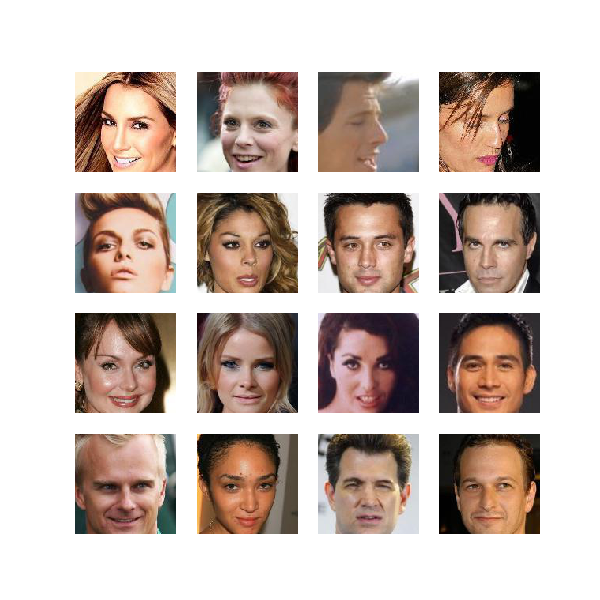

torch.Size([16, 3, 128, 128])


In [6]:
samples = [dataset[i] for i in idx]
if len(samples[0]) > 1:
    X, Y = zip(*samples)
    X = torch.stack(X)
    Y = torch.stack(Y)
else:
    X = torch.stack([s[0] for s in samples])
    Y = None
show_nums(X)
if Y is not None:
    print(Y.shape)
else:
    print(X.shape)

<IPython.core.display.Javascript object>


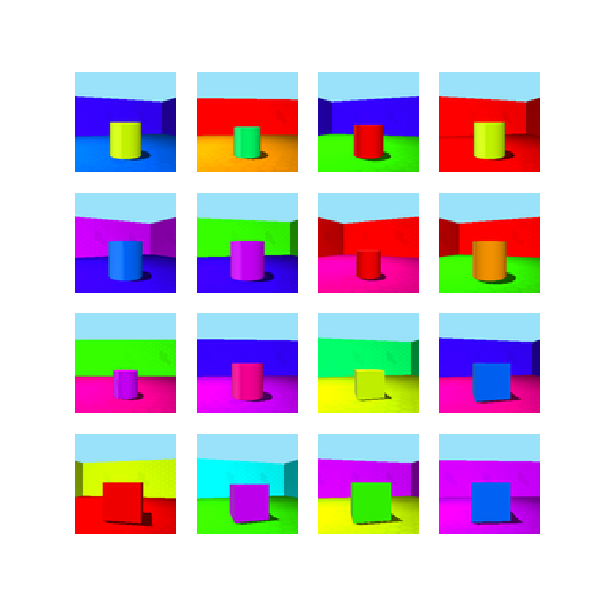

torch.Size([16, 3, 64, 64])


In [14]:
samples = [dataset[i] for i in idx]
if len(samples[0]) > 1:
    X, Y = zip(*samples)
    X = torch.stack(X)
    Y = torch.stack(Y)
else:
    X = torch.stack([s[0] for s in samples])
    Y = None
show_nums(X)
if Y is not None:
    print(Y.shape)
else:
    print(X.shape)

In [13]:
dataset.pre_epoch('train', 1)

Replacing old samples


In [8]:
self = dataset

In [9]:
sel = torch.logical_not(self.labels[:, 2].isclose(torch.tensor(0.))
       + self.labels[:, 2].isclose(torch.tensor(0.3))
       + self.labels[:, 2].isclose(torch.tensor(0.7))) * self.labels[:, -2].isclose(torch.tensor(2.))

rep = (self.labels[:, 2].isclose(torch.tensor(0.))
        + self.labels[:, 2].isclose(torch.tensor(0.3))
        + self.labels[:, 2].isclose(torch.tensor(0.7))) * self.labels[:, -2].isclose(torch.tensor(2.))

replacements = self.images[rep]
replacements.shape

torch.Size([28809, 3, 64, 64])

In [31]:
sidx = torch.arange(self.images.shape[0])[sel]
ridx = torch.arange(self.images.shape[0])[rep]
sidx.shape, ridx.shape

(torch.Size([67201]), torch.Size([28809]))

In [33]:
lost = sel.sum().item()
swaps = rep.sum().item()
lost, swaps

(67201, 28809)

In [34]:
copies, extra = lost // swaps, lost % swaps

In [35]:
extra_idx = torch.randperm(swaps)[:extra]
extra_idx.shape

torch.Size([9583])

In [38]:
reps = torch.cat([ridx]*copies + [extra_idx])
reps.shape

torch.Size([67201])

In [39]:
self.images[sidx] = self.images[reps]

tensor(67201)

In [13]:
67201 / replacements.shape[0]

2.332639105834982

In [15]:
67201 % replacements.shape[0]

9583

In [ ]:
9583

In [ ]:
torch.randperm()

In [3]:
dataset = train.get_dataset('z-celeba', dataroot=os.environ['FOUNDATION_DATA_DIR'], label_type='attr')

NameError: name 'train' is not defined

In [ ]:
i = np.random.randint(len(dataset))

In [ ]:
x, y = dataset[i]
x.shape, y.shape

In [ ]:
plt.imshow(x.permute(1,2,0).numpy())

In [9]:
import h5py as hf

In [6]:
root = os.environ['FOUNDATION_DATA_DIR']
dnames = os.listdir(root)
dataroot = os.path.join(root, '3dshapes')

In [ ]:
path = dataroot
os.listdir(dataroot)

In [10]:
path = os.path.join(dataroot, '3dshapes_train.h5')
f = hf.File(path, 'r+')
list(f.keys())

['images', 'labels']

In [12]:
f['labels'].shape, f['images'].shape

((384000, 6), (384000, 64, 64, 3))

In [15]:
f.attrs.keys()

<KeysViewHDF5 ['factor_order', 'factor_sizes']>